In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
binding_df_full = pd.read_csv('data/GRB2-SH3.binding.csv')
binding_df = binding_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
abundance_df_full = pd.read_csv('data/GRB2-SH3.abundance.csv')
abundance_df = abundance_df_full[['aa_seq','count_e1_s0','count_e1_s1']].dropna().reset_index(drop=True).copy()

In [4]:
data_df = binding_df.copy()
y_cols = data_df.columns[1:] 

In [5]:
X = data_df['aa_seq']
y = data_df[y_cols]

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['aa_seq'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y', '*']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=57, Y=2


In [7]:
data_df_GE = abundance_df_full[['aa_seq','fitness']].copy()

In [8]:
print(abundance_df_full.shape, binding_df_full.shape)

(69744, 33) (46388, 33)


In [9]:
!ls

2022.06.12.GRB2_SH3_abundance.ipynb
2022.06.12.GRB2_SH3_binding.ipynb
2022.06.15.GRB2_SH3_abundance_blackbox_gpmap.ipynb
2022.06.15.GRB2_SH3_binding_blackbox_gpmap.ipynb
2022.10.28.GRB2_SH3_abundance_customGPmap.ipynb
2023.01.22.multilatent_phi_discrete_agnostic_binding.ipynb
2023.01.26.multilatent_phi_GE_abundance.ipynb
2023.01.26.multilatent_phi_GE_binding.ipynb
3d_scatter_lehner.png
abundance_lehner_GE.csv
abundance_phi.txt
binding_phi.txt
data
plots
same_seq_data.csv


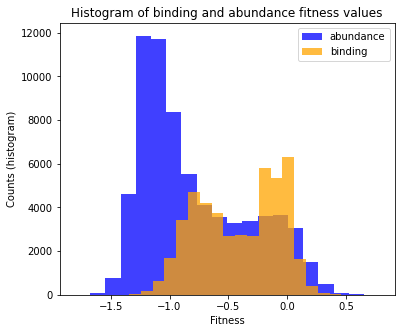

In [10]:
plt.figure(figsize=(6,5))
plt.hist(abundance_df_full['fitness'],bins=20,color='blue',alpha=0.75,label='abundance')
plt.hist(binding_df_full['fitness'],bins=20,color='orange',alpha=0.75,label='binding')
plt.title('Histogram of binding and abundance fitness values')
plt.legend()
plt.xlabel('Fitness')
plt.ylabel('Counts (histogram)')
plt.savefig('plots/GRB2_SH3/histogram_of_fitness_data.png',dpi=200,bbox_inches='tight',facecolor='white')
plt.show()

In [11]:
#gpmapGE = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

number_latent_nodes = 2

gpmapGE = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
                                              alphabet=alphabet,
                                              number_latent_nodes=number_latent_nodes)

#gpmapGE = mavenn.gpmap.MultilayerPerceptronGPMap(L, alphabet)
mp_GE = mavenn.measurement_process_layers.GlobalEpsistasisMP(K=50,
                                                           monotonic=True,
                                                           number_latent_nodes=number_latent_nodes,
                                                           ge_heteroskedasticity_order=2,
                                                           ge_noise_model_type='Gaussian')

In [12]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train_GE, x_test_GE, y_train_GE, y_test_GE = train_test_split(data_df_GE['aa_seq'].values, 
                                                                data_df_GE['fitness'].values, test_size=0.1)

In [13]:
model_GE = mavenn.Model2(gpmap=gpmapGE,
                      mp_list=[mp_GE])

# Set training data
model_GE.set_data(x=x_train_GE,
               #y_list=[data_df['y'].values.reshape(-1,1)],
               y_list=[y_train_GE.reshape(-1,1)],
               shuffle=False)

2023-01-27 11:29:19.634481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


N = 62,769 observations set as training data.
Using 20.2% for validation.
Time to set data: 2.01 sec.


In [14]:
model_GE.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 1198)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 1197)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 multi__additive_gp_map_layer (  (None, 2)           2396        ['Sequence_only[0][0]']          
 Multi_AdditiveGPMapLayer)                                                                        
                                                                                              

In [15]:
# Fit model to data
history = model_GE.fit(learning_rate=.0005,
                    epochs=300,
                    batch_size=300,
                    try_tqdm=False,
                    early_stopping=False,
                    early_stopping_patience=5,
                    linear_initialization=False)

Epoch 1/300
167/167 [==============================] - 2s 8ms/step - loss: 293.5610 - I_var: -0.8037 - val_loss: 258.3418 - val_I_var: -0.6404
Epoch 2/300
167/167 [==============================] - 2s 9ms/step - loss: 227.7629 - I_var: -0.4872 - val_loss: 190.6405 - val_I_var: -0.3131
Epoch 3/300
167/167 [==============================] - 1s 6ms/step - loss: 154.3719 - I_var: -0.1342 - val_loss: 122.6561 - val_I_var: 0.0156
Epoch 4/300
167/167 [==============================] - 1s 7ms/step - loss: 93.8230 - I_var: 0.1570 - val_loss: 72.4840 - val_I_var: 0.2578
Epoch 5/300
167/167 [==============================] - 1s 7ms/step - loss: 51.9539 - I_var: 0.3584 - val_loss: 40.0983 - val_I_var: 0.4142
Epoch 6/300
167/167 [==============================] - 1s 8ms/step - loss: 24.6676 - I_var: 0.4896 - val_loss: 21.5212 - val_I_var: 0.5043
Epoch 7/300
167/167 [==============================] - 1s 8ms/step - loss: 8.9753 - I_var: 0.5651 - val_loss: 14.4503 - val_I_var: 0.5390
Epoch 8/300
167/1

Epoch 59/300
167/167 [==============================] - 1s 5ms/step - loss: -90.6245 - I_var: 1.0445 - val_loss: -80.0002 - val_I_var: 0.9945
Epoch 60/300
167/167 [==============================] - 1s 6ms/step - loss: -90.9509 - I_var: 1.0461 - val_loss: -80.9688 - val_I_var: 0.9993
Epoch 61/300
167/167 [==============================] - 1s 6ms/step - loss: -91.5961 - I_var: 1.0492 - val_loss: -80.7744 - val_I_var: 0.9982
Epoch 62/300
167/167 [==============================] - 1s 5ms/step - loss: -91.9291 - I_var: 1.0508 - val_loss: -81.6236 - val_I_var: 1.0027
Epoch 63/300
167/167 [==============================] - 1s 4ms/step - loss: -92.3268 - I_var: 1.0528 - val_loss: -82.1689 - val_I_var: 1.0053
Epoch 64/300
167/167 [==============================] - 1s 5ms/step - loss: -92.0056 - I_var: 1.0512 - val_loss: -81.8064 - val_I_var: 1.0035
Epoch 65/300
167/167 [==============================] - 1s 6ms/step - loss: -92.6738 - I_var: 1.0544 - val_loss: -82.9817 - val_I_var: 1.0092
Epoch 

167/167 [==============================] - 1s 4ms/step - loss: -115.1988 - I_var: 1.1631 - val_loss: -101.3295 - val_I_var: 1.1005
Epoch 117/300
167/167 [==============================] - 1s 5ms/step - loss: -115.1235 - I_var: 1.1627 - val_loss: -101.8737 - val_I_var: 1.1032
Epoch 118/300
167/167 [==============================] - 1s 4ms/step - loss: -116.2617 - I_var: 1.1682 - val_loss: -102.1414 - val_I_var: 1.1045
Epoch 119/300
167/167 [==============================] - 1s 4ms/step - loss: -116.8335 - I_var: 1.1710 - val_loss: -101.6442 - val_I_var: 1.1023
Epoch 120/300
167/167 [==============================] - 1s 4ms/step - loss: -116.7404 - I_var: 1.1705 - val_loss: -102.8440 - val_I_var: 1.1081
Epoch 121/300
167/167 [==============================] - 1s 4ms/step - loss: -117.4431 - I_var: 1.1739 - val_loss: -103.5349 - val_I_var: 1.1116
Epoch 122/300
167/167 [==============================] - 1s 4ms/step - loss: -118.1646 - I_var: 1.1774 - val_loss: -103.1797 - val_I_var: 1.1100

167/167 [==============================] - 2s 9ms/step - loss: -130.9616 - I_var: 1.2392 - val_loss: -113.1285 - val_I_var: 1.1596
Epoch 173/300
167/167 [==============================] - 1s 6ms/step - loss: -131.3542 - I_var: 1.2411 - val_loss: -112.8370 - val_I_var: 1.1581
Epoch 174/300
167/167 [==============================] - 1s 7ms/step - loss: -131.4020 - I_var: 1.2413 - val_loss: -113.2152 - val_I_var: 1.1599
Epoch 175/300
167/167 [==============================] - 2s 9ms/step - loss: -131.0757 - I_var: 1.2397 - val_loss: -112.9078 - val_I_var: 1.1585
Epoch 176/300
167/167 [==============================] - 1s 8ms/step - loss: -131.3864 - I_var: 1.2412 - val_loss: -111.1475 - val_I_var: 1.1499
Epoch 177/300
167/167 [==============================] - 1s 8ms/step - loss: -131.7121 - I_var: 1.2428 - val_loss: -112.9204 - val_I_var: 1.1586
Epoch 178/300
167/167 [==============================] - 1s 8ms/step - loss: -131.4761 - I_var: 1.2417 - val_loss: -113.0522 - val_I_var: 1.1593

167/167 [==============================] - 1s 5ms/step - loss: -133.6651 - I_var: 1.2523 - val_loss: -113.9586 - val_I_var: 1.1638
Epoch 229/300
167/167 [==============================] - 1s 5ms/step - loss: -133.8989 - I_var: 1.2535 - val_loss: -114.2665 - val_I_var: 1.1653
Epoch 230/300
167/167 [==============================] - 1s 5ms/step - loss: -133.8891 - I_var: 1.2535 - val_loss: -112.2033 - val_I_var: 1.1555
Epoch 231/300
167/167 [==============================] - 1s 5ms/step - loss: -134.2010 - I_var: 1.2549 - val_loss: -113.3896 - val_I_var: 1.1612
Epoch 232/300
167/167 [==============================] - 1s 5ms/step - loss: -133.4915 - I_var: 1.2515 - val_loss: -111.2583 - val_I_var: 1.1506
Epoch 233/300
167/167 [==============================] - 1s 5ms/step - loss: -133.4373 - I_var: 1.2513 - val_loss: -112.2331 - val_I_var: 1.1555
Epoch 234/300
167/167 [==============================] - 1s 5ms/step - loss: -133.8739 - I_var: 1.2533 - val_loss: -113.3092 - val_I_var: 1.1606

167/167 [==============================] - 1s 9ms/step - loss: -134.4867 - I_var: 1.2564 - val_loss: -113.8581 - val_I_var: 1.1636
Epoch 285/300
167/167 [==============================] - 2s 9ms/step - loss: -134.4451 - I_var: 1.2562 - val_loss: -111.9094 - val_I_var: 1.1541
Epoch 286/300
167/167 [==============================] - 2s 9ms/step - loss: -134.4655 - I_var: 1.2563 - val_loss: -111.2863 - val_I_var: 1.1511
Epoch 287/300
167/167 [==============================] - 2s 11ms/step - loss: -134.4479 - I_var: 1.2562 - val_loss: -114.0995 - val_I_var: 1.1648
Epoch 288/300
167/167 [==============================] - 2s 10ms/step - loss: -134.4780 - I_var: 1.2564 - val_loss: -113.4720 - val_I_var: 1.1617
Epoch 289/300
167/167 [==============================] - 2s 9ms/step - loss: -134.3021 - I_var: 1.2555 - val_loss: -113.2537 - val_I_var: 1.1606
Epoch 290/300
167/167 [==============================] - 1s 8ms/step - loss: -134.0299 - I_var: 1.2543 - val_loss: -114.4841 - val_I_var: 1.16

On test data:


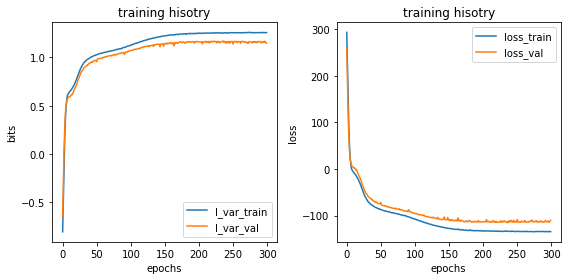

In [16]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model_GE.history['I_var']
val_I_var_hist = model_GE.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model_GE.history['loss'], label='loss_train')
ax.plot(model_GE.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [17]:
# phi = gpmapGE.x_to_phi(x_test_GE)
# phi_train = gpmapGE.x_to_phi(x_train_GE)
from mavenn.src.utils import x_to_ohe

In [18]:
x_test_OHE = x_to_ohe(x=x_test_GE,
                      alphabet=alphabet)


In [19]:
y_hat_multi_GE = model_GE.model.predict(np.hstack([x_test_OHE,y_test_GE.reshape(-1,1)])).ravel()




In [20]:
#model_GE
phi = gpmapGE.x_to_phi(x_test_GE)

In [21]:
type(phi)

numpy.ndarray

In [22]:
phi.shape

(6975, 2)

In [23]:
yhat = mp_GE.phi_to_yhat(phi)

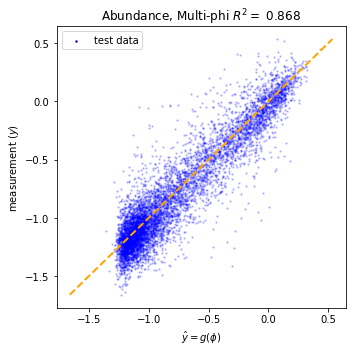

In [30]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

yhat = mp_GE.phi_to_yhat(phi)


lims = [min(min(yhat.numpy().ravel()),min(y_test_GE.ravel())),
        max(max(yhat.numpy().ravel()),max(y_test_GE.ravel()))]

ax.plot(lims,lims,ls='--',color='orange',lw=2)

    
ax.scatter(yhat,y_test_GE,s=2,alpha=0.2,c='b',label='test data')
Rsq = np.corrcoef(yhat.numpy().ravel(),y_test_GE)[0,1]**2

ax.set_xlabel('$\hat{y} = g(\phi)$')
ax.set_ylabel('measurement ($y$)')
ax.set_title(f'Abundance, Multi-phi $R^2 = $ {Rsq:.3f}')
leg = ax.legend()

for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.tight_layout()
fig.savefig('plots/GRB2_SH3/global_epistasis_abundance_multi_phi.png',dpi=300,bbox_inches='tight')    


In [26]:
#theta_lc_GE = gpmapGE.get_theta(model_GE,gauge='consensus')['theta_lc']
np.squeeze(model_GE.model.layers[2].get_weights()[1])

array([[[-2.89846212e-01, -1.44706681e-01, -1.11768179e-01, ...,
         -2.91327477e-01, -3.22456181e-01,  3.04017991e-01],
        [-1.62747145e-01, -4.87564355e-02, -8.02201331e-02, ...,
         -7.31019303e-02,  7.20895231e-02,  7.11149514e-01],
        [-5.46401255e-02, -1.74998954e-01, -3.34039211e-01, ...,
         -1.60602912e-01,  6.36624172e-03,  1.00707889e+00],
        ...,
        [-2.48917252e-01, -2.08533898e-01,  1.12945795e-01, ...,
         -3.20387959e-01, -1.95837572e-01, -1.28351256e-01],
        [-1.12132870e-01,  1.73214208e-02, -2.96273641e-03, ...,
         -1.94864959e-01, -2.12718606e-01, -1.74838260e-01],
        [ 4.49301124e-33,  5.00433843e-33,  3.15753138e-33, ...,
         -7.10415962e-33,  8.98902587e-33, -4.37602028e-02]],

       [[-8.19026753e-02, -1.52091216e-02, -6.63776919e-02, ...,
         -8.63846168e-02,  1.93190128e-02, -6.53923392e-01],
        [-2.39591748e-01, -7.18815252e-02, -1.81095764e-01, ...,
          7.29093775e-02, -5.59848286e

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(theta_2_lc[0].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[0].set_xlabel('Theta-1 multi-discrete monotonic')
ax[0].set_ylabel('Theta global epistasis')

ax[1].scatter(theta_2_lc[1].ravel(),theta_lc_GE.ravel(),c='blue',s=5,alpha=0.3)
ax[1].set_xlabel('Theta-2 multi-discrete monotonic')
ax[1].set_ylabel('Theta global epistasis')

fig.tight_layout()

In [ ]:
lehner_binding_singles_df = pd.read_csv('data/GRB2-SH3.singles_binding.csv',index_col=[0])
lehner_binding_singles_df

In [ ]:
binding_singles_transformed_df = pd.DataFrame(np.nan*np.ones(shape=(57,21)),columns=alphabet)
binding_singles_transformed_df.head()

In [ ]:
for idx in lehner_binding_singles_df.index:

    mutant = lehner_binding_singles_df.loc[idx]['Mut']
    value = lehner_binding_singles_df.loc[idx]['fitness']
    
    pos = lehner_binding_singles_df.loc[idx]['Pos']-1
    binding_singles_transformed_df[mutant][pos] = value

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]
Rsq = np.corrcoef(theta_2_lc[0].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[0].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 1')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

ax = axs[1]
Rsq = np.corrcoef(theta_2_lc[1].ravel(),binding_singles_transformed_df.fillna(0).values.ravel())[0,1]**2
ax.scatter(theta_2_lc[1].ravel(),binding_singles_transformed_df.values.ravel(),s=3,alpha=0.3,color='blue')
ax.set_xlabel(' $\\theta$ - 2')
ax.set_ylabel(' Binding, singles - Lehner')
ax.set_title(f'$R^2 = $ {Rsq:.3f}')

fig.tight_layout()

#fig.savefig('plots/GRB2_SH3/GRB2_SH3.singles_binding_comparison_to_Lehner.png',dpi=200,bbox_inches='tight')


In [ ]:
# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[12,4])

# Draw heatmap
ax, cb = mavenn.heatmap(ax=ax,
                        values=binding_singles_transformed_df.values,
                        alphabet=alphabet,
                        seq=model.x_stats['consensus_seq'],
                        seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                        cmap='RdBu',
                        cbar=True,
                        #clim = [-5,1],
                        cmap_size='2%',
                        cmap_pad=.3,
                        ccenter=0)

# Style colorbar
cb.set_label('Additive effect - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
ax.set_title('Lehner - binding')

#fig.savefig('plots/GRB2_SH3/Lehner_GP_map_binding.png',dpi=300,bbox_inches='tight')